In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage as si
from scipy import ndimage
from scipy.spatial import distance as dist
from xml.dom import minidom
import xml.etree.ElementTree as ET


In [3]:
# Two functions nescessary for the determination of the perspective transformation
# author of both functions:    Adrian Rosebrock
# https://github.com/PyImageSearch/imutils/blob/c12f15391fcc945d0d644b85194b8c044a392e0a/imutils/perspective.py

# function for arranging 4 coordinates in clockwise order starting at the top left
def order_points(pts):

    xSorted = pts[np.argsort(pts[:, 0]), :]
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    
    return np.array([tl, bl, br, tr], dtype="float32")

# function for defining the transformation matrix given four coordinates
def get_transform(p):
    
    w1 = np.sqrt(((p[0][0][0] - p[3][0][0]) ** 2) + ((p[0][0][1] - p[3][0][1]) ** 2))
    w2 = np.sqrt(((p[1][0][0] - p[2][0][0]) ** 2) + ((p[1][0][1] - p[2][0][1]) ** 2)) 
 
    h1 = np.sqrt(((p[0][0][0] - p[1][0][0]) ** 2) + ((p[0][0][1] - p[1][0][1]) ** 2))
    h2 = np.sqrt(((p[2][0][0] - p[3][0][0]) ** 2) + ((p[2][0][1] - p[3][0][1]) ** 2))
    
    p1 = np.array([p[0][0][0], p[0][0][1]])
    p2 = np.array([p[1][0][0], p[1][0][1]])
    p3 = np.array([p[2][0][0], p[2][0][1]])    
    p4 = np.array([p[3][0][0], p[3][0][1]])
                   
    wmax = max(int(w1), int(w2))
    hmax = max(int(h1), int(h2))
    
    
    i = np.float32([p1, p2, p3, p4])
    o = np.float32([[0, 0], [0, hmax - 1], [wmax - 1, hmax - 1], [wmax - 1, 0]])
                        
    M = cv2.getPerspectiveTransform(i, o)
    
    return M, hmax, wmax

In [4]:
# importing the image (recommended minimum resolution ~ 4000x3000, image taken from close by)
os.chdir('C:\\Users\\sjoerd.kra\\Documents\\GitHub\\Datascience\\Seedling Leaf Area\\Notebooks')

# choose to apply the thresholding to either the gray or saturation image, choose from ('gray', 'sat')
thr = 'gray'

dataset = 'S2-2306'
tray = 'Tray1'
filetype = '.png'
img1 = cv2.imread(os.getcwd()+'/Data/'+dataset+'/TrayImages/'+str(tray)+filetype)


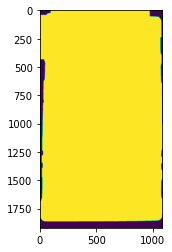

In [5]:
# creating a binary cutout of the tray

if img1.shape[1] >= img1.shape[0]:
    img1 = np.rot90(img1, 1, axes = (0, 1))
    
res = img1.shape[0]/4000

if thr == 'gray':
    #Original version based on otsu thresholding on the gray image
    gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(int(200*res),int(200*res)))
    gray_equalised = clahe.apply(gray)
    ret, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_OTSU)
    mask = ndimage.binary_fill_holes(si.morphology.binary_closing(ndimage.binary_dilation(~thresh, np.ones([int(res*5), int(res*5)])), np.ones((int(res*30),int(res*30)))))
    mask = ndimage.binary_opening(mask, np.ones([int(res*100), int(res*100)])).astype(np.uint8)

else:
    #Alternative version based on otsu thresholding on the saturation map
    HSV = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(int(res*200),int(res*200)))
    HSV_equalised = clahe.apply(HSV[:,:,1])
    ret, thresh = cv2.threshold(HSV_equalised, 50, 255, cv2.THRESH_OTSU)
    mask = ndimage.binary_fill_holes(ndimage.binary_closing(ndimage.binary_dilation(thresh, np.ones([int(res*5), int(res*5)])), np.ones([int(res*20), int(res*20)])))
    mask = ndimage.binary_opening(mask, np.ones([int(res*100), int(res*100)])).astype(np.uint8)

plt.imshow(mask)
plt.show()

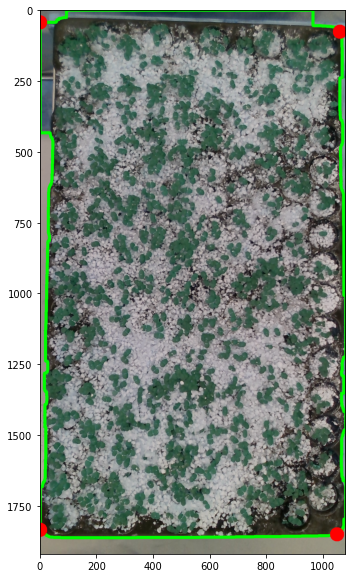

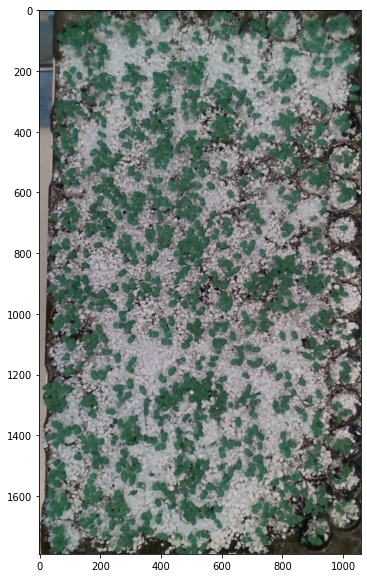

In [8]:
# projecting the tray to a birds eye view
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]
poly = cv2.approxPolyDP(contours[0][:,0,:], 500, True)

poly2 = np.empty(poly.shape)
poly2[:,0,:] = order_points(poly[:,0,:])

M, hmax, wmax = get_transform(poly2)

img2 = cv2.warpPerspective(img1, M, (wmax, hmax), flags=cv2.INTER_LINEAR)

# Image to check whether the corner coordinates where correctly determined
check = np.ascontiguousarray(img1, dtype=np.uint8)
cv2.drawContours(check, contours, -1, (0, 255, 0), 10)
cv2.drawContours(check, poly, -1, (255, 0, 0), 50)
plt.figure(figsize = (10,10))
plt.imshow(check, cmap = 'gray')
plt.show()

if img2.shape[1] >= img2.shape[0]:
    img2 = np.rot90(img2, 1, axes = (0, 1))

#plot image containing contour and corners to check whether algorithm was succesfull
plt.figure(figsize = (10,10))
plt.imshow(img2)
plt.show()


[[[  55.   43.]]

 [[   0. 1834.]]

 [[1048. 1850.]]

 [[1058.   76.]]]
[[[  55.   43.]]

 [[   0. 1834.]]

 [[1048. 1850.]]

 [[1058.   76.]]]


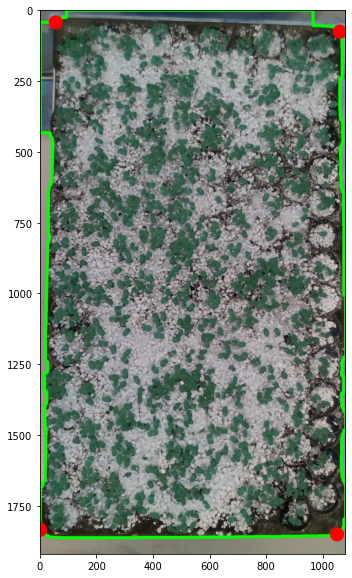

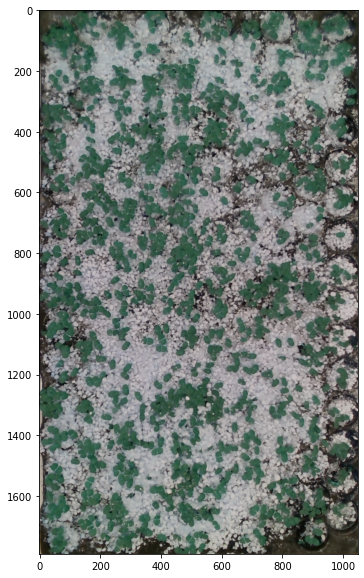

In [15]:
#change corner values by hand (optional)
polynew = np.copy(poly2)
#polynew[0,:,:] = [,]
#polynew[1,:,:] = [,]
#polynew[2,:,:] = [,]
#polynew[3,:,:] = [,]

print(polynew)

M, hmax, wmax = get_transform(polynew)

img2 = cv2.warpPerspective(img1, M, (wmax, hmax), flags=cv2.INTER_LINEAR)

# Image to check whether the corner coordinates where correctly determined
check = np.ascontiguousarray(img1, dtype=np.uint8)
cv2.drawContours(check, contours, -1, (0, 255, 0), 10)
cv2.drawContours(check, poly, -1, (255, 0, 0), 50)
plt.figure(figsize = (10,10))
plt.imshow(check, cmap = 'gray')
plt.show()

if img2.shape[1] >= img2.shape[0]:
    img2 = np.rot90(img2, 1, axes = (0, 1))

plt.figure(figsize = (10,10))
plt.imshow(img2)
plt.show()

In [10]:
#cutting out the individual pods

dh = int(img2.shape[0]/31)
dw = int(img2.shape[1]/20)
r = int(1.265 * dw)
    
height, width = img2[:,:,0].shape

pods = np.zeros([2*r, 2*r, 3, 150])
k = 0

for i in range(0, 5):
    for j in range(0, 15):
        mask = np.zeros((height,width), np.uint8)
        cv2.circle(mask,((4*i+3)*dw, (2*j+1)*dh),r, 1,thickness=-1)
        pod = (mask[:, :, None]*img2)[max(0, ((2*j+1)*dh-r)):min(height, ((2*j+1)*dh+r)), 
                                      max(0, ((4*i+3)*dw-r)):min(width, ((4*i+3)*dw+r)), :]
        
        pods[:pod.shape[0],:pod.shape[1],:,k] = pod
        plt.imsave(os.getcwd()+'/Data/'+dataset+'/PodImages/'+str(dataset)+'_'+str(tray)+'_'+str((2*i)+2)+'.'+str(j+1)+'.png', (pods[:,:,:,k]/255), dpi = 200)
    
        k = k+1
        
for i in range(0, 5):
    for j in range(1, 16):
        mask = np.zeros((height,width), np.uint8)
        cv2.circle(mask,((4*i+1)*dw, 2*j*dh),r, 1,thickness=-1)
        pod = (mask[:, :, None]*img2)[max(0, (2*j*dh-r)):min(height, (2*j*dh+r)), 
                                      max(0, ((4*i+1)*dw-r)):min(width, ((4*i+1)*dw+r)), :]
        
        pods[:pod.shape[0],:pod.shape[1],:,k] = pod
        plt.imsave(os.getcwd()+'/Data/'+dataset+'/PodImages/'+str(dataset)+'_'+str(tray)+'_'+str((2*i)+1)+'.'+str(j)+'.png', (pods[:,:,:,k]/255), dpi = 200)

        k = k+1